## Imports

In [1]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from pathlib import Path
from datetime import datetime
import metpy.io as mtio
import metpy.calc as mtcl
import metpy.units as mtun
import pandas as pd
from tqdm import tqdm
import math

sns.set()

## Reading data

In [2]:
data_dir = Path(os.getcwd()).parent/"data"/"interm"
main_ds = pl.read_csv(data_dir/"train_val.csv", null_values="NA")

In [3]:
print(main_ds.head())

shape: (5, 10)
┌─────────────────────┬────────────────────┬────────┬─────────┬───┬────────────────────┬────────────────────┬────────────────────┬────────┐
│ flightid            ┆ hora_ref           ┆ origem ┆ destino ┆ … ┆ metar              ┆ prev_troca_cabecei ┆ troca_cabeceira_ho ┆ espera │
│ ---                 ┆ ---                ┆ ---    ┆ ---     ┆   ┆ ---                ┆ ra                 ┆ ra_anterior        ┆ ---    │
│ str                 ┆ str                ┆ str    ┆ str     ┆   ┆ str                ┆ ---                ┆ ---                ┆ i64    │
│                     ┆                    ┆        ┆         ┆   ┆                    ┆ i64                ┆ i64                ┆        │
╞═════════════════════╪════════════════════╪════════╪═════════╪═══╪════════════════════╪════════════════════╪════════════════════╪════════╡
│ 504a62621cd231d6ab6 ┆ 2022-06-01T01:00:0 ┆ SBCF   ┆ SBFL    ┆ … ┆ METAR SBFL 010000Z ┆ 0                  ┆ 1                  ┆ 0      │
│ 7e6

In [4]:
main_ds.schema

OrderedDict([('flightid', String),
             ('hora_ref', String),
             ('origem', String),
             ('destino', String),
             ('url_img_satelite', String),
             ('metaf', String),
             ('metar', String),
             ('prev_troca_cabeceira', Int64),
             ('troca_cabeceira_hora_anterior', Int64),
             ('espera', Int64)])

## Description of each column

In [5]:
print(main_ds.describe())

shape: (9, 11)
┌────────────┬────────────────────┬───────────────────┬────────┬───┬───────────────────┬───────────────────┬───────────────────┬──────────┐
│ statistic  ┆ flightid           ┆ hora_ref          ┆ origem ┆ … ┆ metar             ┆ prev_troca_cabece ┆ troca_cabeceira_h ┆ espera   │
│ ---        ┆ ---                ┆ ---               ┆ ---    ┆   ┆ ---               ┆ ira               ┆ ora_anterior      ┆ ---      │
│ str        ┆ str                ┆ str               ┆ str    ┆   ┆ str               ┆ ---               ┆ ---               ┆ f64      │
│            ┆                    ┆                   ┆        ┆   ┆                   ┆ f64               ┆ f64               ┆          │
╞════════════╪════════════════════╪═══════════════════╪════════╪═══╪═══════════════════╪═══════════════════╪═══════════════════╪══════════╡
│ count      ┆ 211679             ┆ 211679            ┆ 211679 ┆ … ┆ 210055            ┆ 211679.0          ┆ 211679.0          ┆ 211679.0 │
│ nul

### Casting 'hora_ref' to datetime

In [6]:
main_ds = main_ds.with_columns(
    pl.col("hora_ref").cast(pl.Datetime)
)
print(main_ds.head())

shape: (5, 10)
┌──────────────────────┬──────────────┬────────┬─────────┬───┬──────────────────────┬──────────────────────┬─────────────────────┬────────┐
│ flightid             ┆ hora_ref     ┆ origem ┆ destino ┆ … ┆ metar                ┆ prev_troca_cabeceira ┆ troca_cabeceira_hor ┆ espera │
│ ---                  ┆ ---          ┆ ---    ┆ ---     ┆   ┆ ---                  ┆ ---                  ┆ a_anterior          ┆ ---    │
│ str                  ┆ datetime[μs] ┆ str    ┆ str     ┆   ┆ str                  ┆ i64                  ┆ ---                 ┆ i64    │
│                      ┆              ┆        ┆         ┆   ┆                      ┆                      ┆ i64                 ┆        │
╞══════════════════════╪══════════════╪════════╪═════════╪═══╪══════════════════════╪══════════════════════╪═════════════════════╪════════╡
│ 504a62621cd231d6ab67 ┆ 2022-06-01   ┆ SBCF   ┆ SBFL    ┆ … ┆ METAR SBFL 010000Z   ┆ 0                    ┆ 1                   ┆ 0      │
│ e67

## Processing 'metar'

In [7]:
main_ds = main_ds.with_columns(
    pl.col("metar").fill_null("")
)

In [8]:
def get_parsed_metars(dataset):
    n = dataset.shape[0]
    elevs = []
    temps = []
    dew_pts = []
    visibs = []
    wind_dirs = []
    wind_spds = []
    wind_gusts = []
    skyc1s = []
    skylev1s = []
    skyc2s = []
    skylev2s = []
    skyc3s = []
    skylev3s = []
    skyc4s = []
    skylev4s = []
    cloud_covs = []
    altimeters = []
    pressures = [] # mtcl.altimeter_to_sea_level_pressure

    for i in tqdm(range(n)):
        metar = dataset["metar"][i]
        hora_ref = dataset["hora_ref"][i]
        if metar == "":
            elevs.append(None)
            temps.append(None)
            dew_pts.append(None)
            visibs.append(None)
            wind_dirs.append(None)
            wind_spds.append(None)
            wind_gusts.append(None)
            skyc1s.append(None)
            skylev1s.append(None)
            skyc2s.append(None)
            skylev2s.append(None)
            skyc3s.append(None)
            skylev3s.append(None)
            skyc4s.append(None)
            skylev4s.append(None)
            cloud_covs.append(None)
            altimeters.append(None)
            pressures.append(None)
            continue
        try:
            metar = metar.replace(" COR ", " ")
            metar = metar.replace(" AUTO ", " ")
            metar = metar.replace(" AO1 ", " ")
            metar = metar.replace(" AO2 ", " ")
            metar = mtio.metar.parse_metar(metar, hora_ref.year, hora_ref.month)
            elevs.append(None if math.isnan(metar.elevation) else metar.elevation)
            temps.append(None if math.isnan(metar.temperature) else metar.temperature)
            dew_pts.append(None if math.isnan(metar.dewpoint) else metar.dewpoint)
            visibs.append(None if math.isnan(metar.visibility) else metar.visibility)
            wind_dirs.append(None if math.isnan(metar.wind_direction) else np.deg2rad(metar.wind_direction))
            wind_spds.append(None if math.isnan(metar.wind_speed) else metar.wind_speed)
            wind_gusts.append(None if math.isnan(metar.wind_gust) else metar.wind_gust)
            skyc1s.append(None if type(metar.skyc1) != str else metar.skyc1)
            skylev1s.append(None if math.isnan(metar.skylev1) else metar.skylev1)
            skyc2s.append(None if type(metar.skyc2) != str else metar.skyc2)
            skylev2s.append(None if math.isnan(metar.skylev2) else metar.skylev2)
            skyc3s.append(None if type(metar.skyc3) != str else metar.skyc3)
            skylev3s.append(None if math.isnan(metar.skylev3) else metar.skylev3)
            skyc4s.append(None if type(metar.skyc4) != str else metar.skyc4)
            skylev4s.append(None if math.isnan(metar.skylev4) else metar.skylev4)
            cloud_covs.append(None if math.isnan(metar.cloudcover) else metar.cloudcover)
            altimeters.append(None if math.isnan(metar.altimeter) else metar.altimeter)
            if not (math.isnan(metar.altimeter) or math.isnan(metar.elevation) or math.isnan(metar.temperature)):
                pressures.append(mtcl.altimeter_to_station_pressure(
                    mtun.pint.Quantity(metar.altimeter, "inHg"), 
                    mtun.pint.Quantity(metar.elevation, "meters")
                ).to("hPa").magnitude / 1_013.25) # convert to 'atm'
            else:
                pressures.append(None)
        except Exception as e:
            print(e)
            elevs.append(None)
            temps.append(None)
            dew_pts.append(None)
            visibs.append(None)
            wind_dirs.append(None)
            wind_spds.append(None)
            wind_gusts.append(None)
            skyc1s.append(None)
            skylev1s.append(None)
            skyc2s.append(None)
            skylev2s.append(None)
            skyc3s.append(None)
            skylev3s.append(None)
            skyc4s.append(None)
            skylev4s.append(None)
            cloud_covs.append(None)
            altimeters.append(None)
            pressures.append(None)
    return elevs, temps, dew_pts, visibs, wind_dirs, wind_spds, wind_gusts, skyc1s, skylev1s, \
            skyc2s, skylev2s, skyc3s, skylev3s, skyc4s, skylev4s, cloud_covs, altimeters, pressures

In [10]:
columns = [
    "elevation", "air_temperature", "dew_point_temp", "visibility", "wind_direction_rad", "wind_speed", "wind_gust", 
    "low_cloud_type", "low_cloud_level", "medium_cloud_type", "medium_cloud_level", "high_cloud_type", 
    "high_cloud_level", "highest_cloud_type", "highest_cloud_level", "cloud_coverage_oktas", "altimeter", "pressure_station_level_atm"
]
metar_data = get_parsed_metars(main_ds)
metar_data = pl.DataFrame(metar_data, schema=columns)
metar_data

 71%|█████████████████████████████████████████████████████████████████                           | 149798/211679 [03:16<01:28, 702.28it/s]

Line 1: expected one of:

    - [\d] from METAR::datetime
    - "Z" from METAR::datetime

     1 | METAR SBSV 051300 10012KT 9999 FEW021 SCT050 28/24 Q1014=
                          ^
Line 1: expected one of:

    - [\d] from METAR::datetime
    - "Z" from METAR::datetime

     1 | METAR SBSV 051300 10012KT 9999 FEW021 SCT050 28/24 Q1014=
                          ^
Line 1: expected one of:

    - [\d] from METAR::datetime
    - "Z" from METAR::datetime

     1 | METAR SBSV 051400 09013KT 9999 VCSH FEW021 SCT050 29/24 Q1013=
                          ^
Line 1: expected one of:

    - [\d] from METAR::datetime
    - "Z" from METAR::datetime

     1 | METAR SBSV 051400 09013KT 9999 VCSH FEW021 SCT050 29/24 Q1013=
                          ^
Line 1: expected one of:

    - [\d] from METAR::datetime
    - "Z" from METAR::datetime

     1 | METAR SBSV 051400 09013KT 9999 VCSH FEW021 SCT050 29/24 Q1013=
                          ^
Line 1: expected one of:

    - [\d] from METAR::datetime
  

 78%|███████████████████████████████████████████████████████████████████████▌                    | 164630/211679 [03:35<01:00, 778.88it/s]

Line 1: expected one of:

    - [\d] from METAR::datetime
    - "Z" from METAR::datetime

     1 | METAR SBFL 221300 17006KT 9999 BKN020 24/16 Q1017=
                          ^
Line 1: expected one of:

    - [\d] from METAR::datetime
    - "Z" from METAR::datetime

     1 | METAR SBFL 221300 17006KT 9999 BKN020 24/16 Q1017=
                          ^


100%|████████████████████████████████████████████████████████████████████████████████████████████| 211679/211679 [04:39<00:00, 757.17it/s]


elevation,air_temperature,dew_point_temp,visibility,wind_direction_rad,wind_speed,wind_gust,low_cloud_type,low_cloud_level,medium_cloud_type,medium_cloud_level,high_cloud_type,high_cloud_level,highest_cloud_type,highest_cloud_level,cloud_coverage_oktas,altimeter,pressure_station_level_atm
i64,f64,f64,i64,f64,f64,f64,str,f64,str,f64,str,f64,str,f64,i64,f64,f64
5,14.0,7.0,9999,2.96706,9.0,null,"""BKN""",3000.0,null,null,null,null,null,null,6,30.120583,1.006362
5,14.0,7.0,9999,2.96706,9.0,null,"""BKN""",3000.0,null,null,null,null,null,null,6,30.120583,1.006362
828,21.0,14.0,10000,2.094395,6.0,null,null,null,null,null,null,null,null,null,0,30.061523,0.910229
908,10.0,10.0,7000,1.745329,6.0,null,"""BKN""",400.0,"""OVC""",1200.0,null,null,null,null,8,30.091053,0.902375
6,27.0,21.0,9999,1.919862,8.0,null,"""FEW""",2300.0,null,null,null,null,null,null,2,29.943403,1.000324
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
803,23.0,17.0,9999,6.108652,14.0,null,"""SCT""",3000.0,null,null,null,null,null,null,4,29.854813,0.906588
19,29.0,23.0,9999,1.745329,7.0,null,"""BKN""",2000.0,null,null,null,null,null,null,6,29.854813,0.995828
3,29.0,22.0,9999,5.585054,10.0,null,"""FEW""",3500.0,"""BKN""",10000.0,null,null,null,null,6,29.677633,0.9918


### Merging with original set

In [11]:
main_ds = pl.concat([main_ds.drop("metar", "metaf"), metar_data], how="horizontal")

In [12]:
main_ds

flightid,hora_ref,origem,destino,url_img_satelite,prev_troca_cabeceira,troca_cabeceira_hora_anterior,espera,elevation,air_temperature,dew_point_temp,visibility,wind_direction_rad,wind_speed,wind_gust,low_cloud_type,low_cloud_level,medium_cloud_type,medium_cloud_level,high_cloud_type,high_cloud_level,highest_cloud_type,highest_cloud_level,cloud_coverage_oktas,altimeter,pressure_station_level_atm
str,datetime[μs],str,str,str,i64,i64,i64,i64,f64,f64,i64,f64,f64,f64,str,f64,str,f64,str,f64,str,f64,i64,f64,f64
"""504a62621cd231…",2022-06-01 01:00:00,"""SBCF""","""SBFL""","""http://satelit…",0,1,0,5,14.0,7.0,9999,2.96706,9.0,null,"""BKN""",3000.0,null,null,null,null,null,null,6,30.120583,1.006362
"""b0fd0f83644625…",2022-06-01 01:00:00,"""SBPA""","""SBFL""","""http://satelit…",0,1,0,5,14.0,7.0,9999,2.96706,9.0,null,"""BKN""",3000.0,null,null,null,null,null,null,6,30.120583,1.006362
"""1210f0ca07ddca…",2022-06-01 01:00:00,"""SBSP""","""SBCF""","""http://satelit…",0,0,0,828,21.0,14.0,10000,2.094395,6.0,null,null,null,null,null,null,null,null,null,0,30.061523,0.910229
"""b25032f34507cc…",2022-06-01 01:00:00,"""SBGR""","""SBCT""","""http://satelit…",0,0,0,908,10.0,10.0,7000,1.745329,6.0,null,"""BKN""",400.0,"""OVC""",1200.0,null,null,null,null,8,30.091053,0.902375
"""00762a9892ecba…",2022-06-01 01:00:00,"""SBSP""","""SBSV""","""http://satelit…",0,1,0,6,27.0,21.0,9999,1.919862,8.0,null,"""FEW""",2300.0,null,null,null,null,null,null,2,29.943403,1.000324
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""0a98b5dca23575…",2023-02-16 13:00:00,"""SBCT""","""SBSP""","""http://satelit…",0,0,0,803,23.0,17.0,9999,6.108652,14.0,null,"""SCT""",3000.0,null,null,null,null,null,null,4,29.854813,0.906588
"""000143522a56fa…",2023-02-16 13:00:00,"""SBSP""","""SBRF""","""http://satelit…",0,0,0,19,29.0,23.0,9999,1.745329,7.0,null,"""BKN""",2000.0,null,null,null,null,null,null,6,29.854813,0.995828
"""1067786192e3ee…",2023-02-16 13:00:00,"""SBSP""","""SBRJ""","""http://satelit…",0,0,0,3,29.0,22.0,9999,5.585054,10.0,null,"""FEW""",3500.0,"""BKN""",10000.0,null,null,null,null,6,29.677633,0.9918


### Reordering columns (labels last)

In [13]:
main_ds = main_ds.select([pl.all().exclude("espera"), pl.col("espera")])

In [15]:
main_ds.write_csv("with_metar.csv", null_value="NA")

## EDA

In [9]:
main_ds = pl.read_csv("with_metar.csv", null_values="NA")

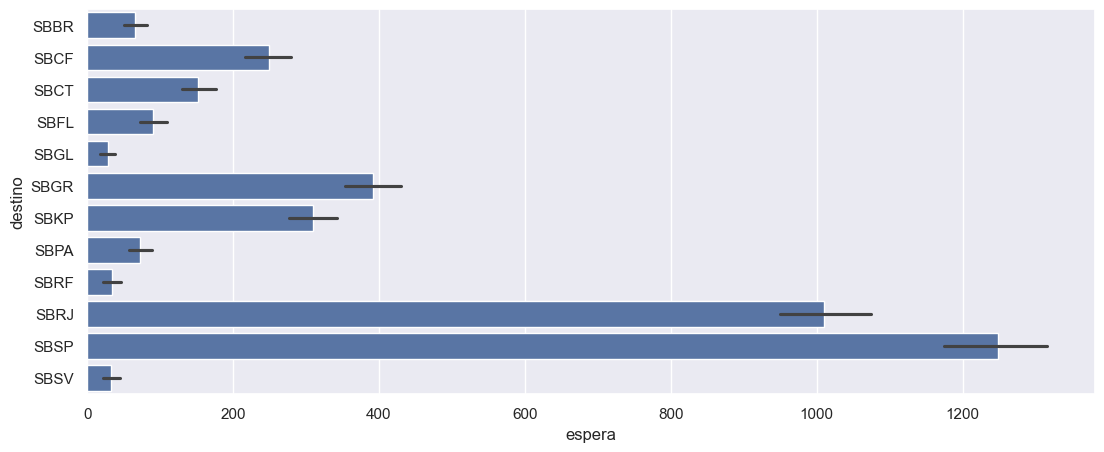

In [10]:
g = sns.barplot(data=main_ds.sort("destino"), y="destino", x="espera", estimator="sum")
g.figure.set_size_inches(13, 5)

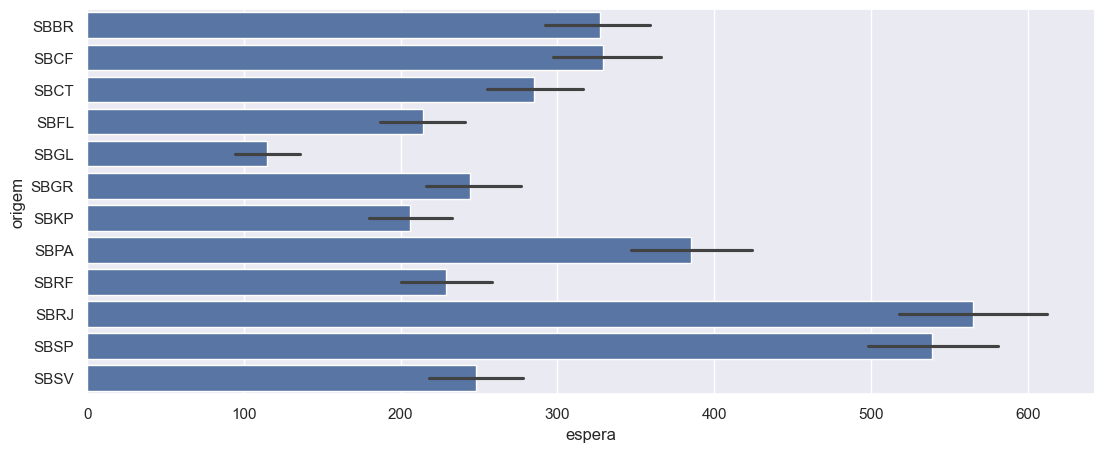

In [11]:
g = sns.barplot(data=main_ds.sort("origem"), y="origem", x="espera", estimator="sum")
g.figure.set_size_inches(13, 5)

In [14]:
print("% de valores nulos")
(100 * main_ds.null_count() / main_ds.shape[0])

% de valores nulos


flightid,hora_ref,origem,destino,url_img_satelite,prev_troca_cabeceira,troca_cabeceira_hora_anterior,elevation,air_temperature,dew_point_temp,visibility,wind_direction_rad,wind_speed,wind_gust,low_cloud_type,low_cloud_level,medium_cloud_type,medium_cloud_level,high_cloud_type,high_cloud_level,highest_cloud_type,highest_cloud_level,cloud_coverage_oktas,altimeter,pressure_station_level_atm,espera
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.0,0.0,0.0,0.0,1.387951,0.0,0.0,0.772868,0.917899,1.070489,0.781372,6.036499,0.774758,99.069818,28.728405,30.744193,59.273712,59.273712,87.371444,87.371444,99.167608,99.167608,0.772868,0.906561,0.918372,0.0


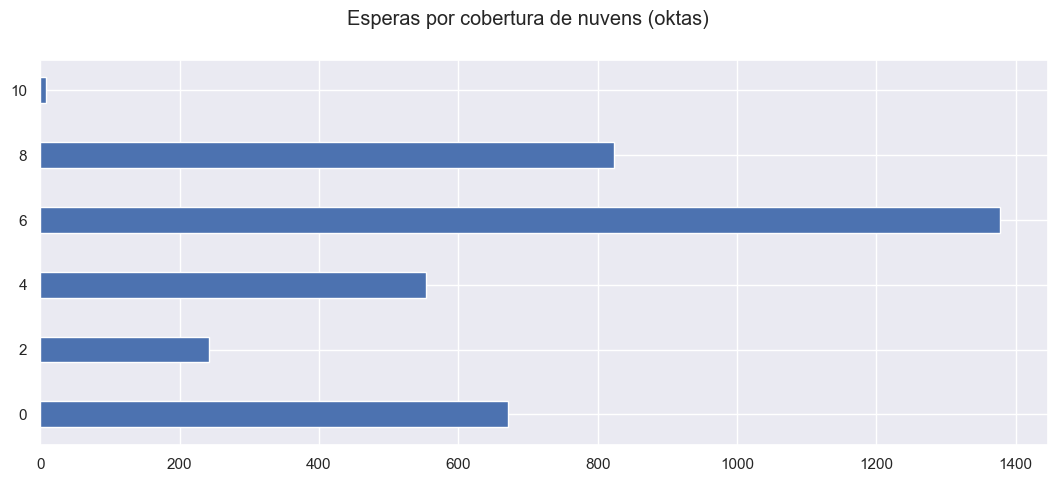

In [15]:
d = main_ds.group_by("cloud_coverage_oktas").agg((pl.col("espera") == 1).sum())
fig = plt.figure(figsize=(13, 5))
_ = plt.suptitle("Esperas por cobertura de nuvens (oktas)")
_ = plt.barh(d["cloud_coverage_oktas"], d["espera"])

<Axes: xlabel='air_temperature', ylabel='Density'>

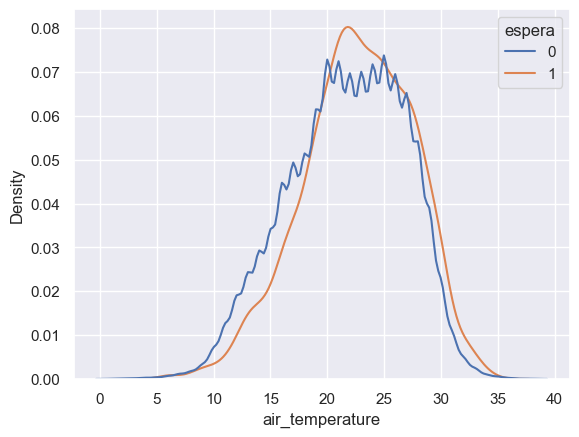

In [16]:
sns.kdeplot(data=main_ds[["air_temperature", "espera"]], hue="espera", x="air_temperature", common_norm=False)

<Axes: xlabel='pressure_station_level_atm', ylabel='Density'>

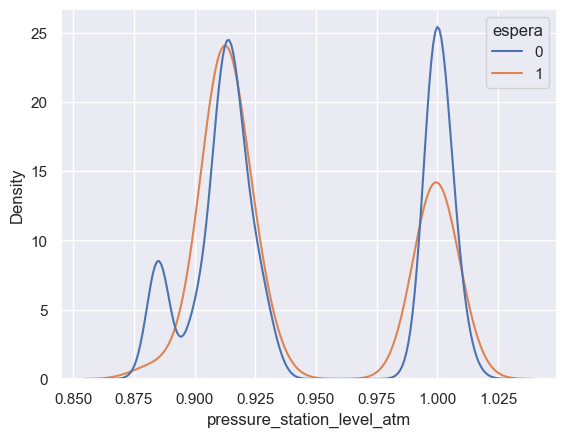

In [17]:
sns.kdeplot(data=main_ds[["pressure_station_level_atm", "espera"]].filter(pl.col("pressure_station_level_atm") > 0.5), hue="espera", x="pressure_station_level_atm", common_norm=False)

<Axes: xlabel='elevation', ylabel='Density'>

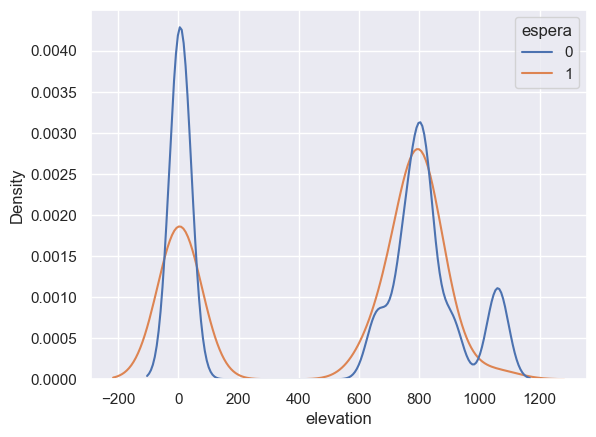

In [18]:
sns.kdeplot(data=main_ds[["elevation", "espera"]], hue="espera", x="elevation", common_norm=False)

In [19]:
main_ds[["elevation", "pressure_station_level_atm"]].filter(pl.col("elevation").is_not_null(), pl.col("pressure_station_level_atm").is_not_null()).corr()

elevation,pressure_station_level_atm
f64,f64
1.0,-0.993516
-0.993516,1.0


<Axes: xlabel='altimeter', ylabel='Density'>

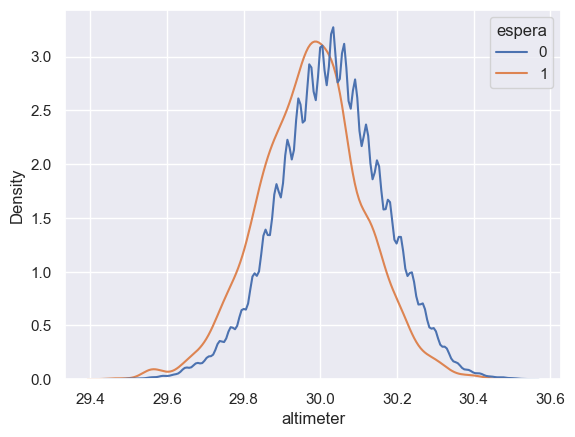

In [20]:
sns.kdeplot(data=main_ds[["altimeter", "espera"]].filter(pl.col("altimeter") > 5), hue="espera", x="altimeter", common_norm=False)

<Axes: xlabel='dew_point_temp', ylabel='Density'>

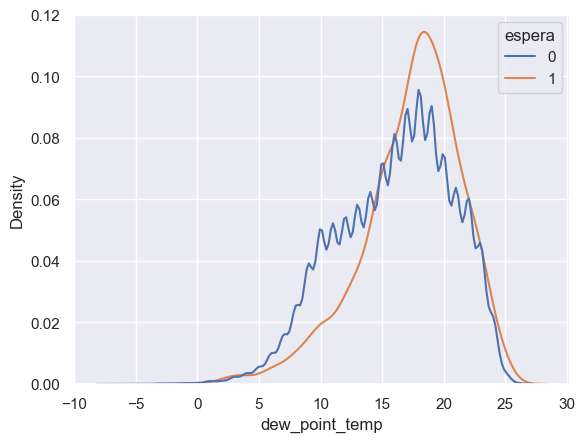

In [21]:
sns.kdeplot(data=main_ds[["dew_point_temp", "espera"]], hue="espera", x="dew_point_temp", common_norm=False)

<Axes: xlabel='visibility', ylabel='Density'>

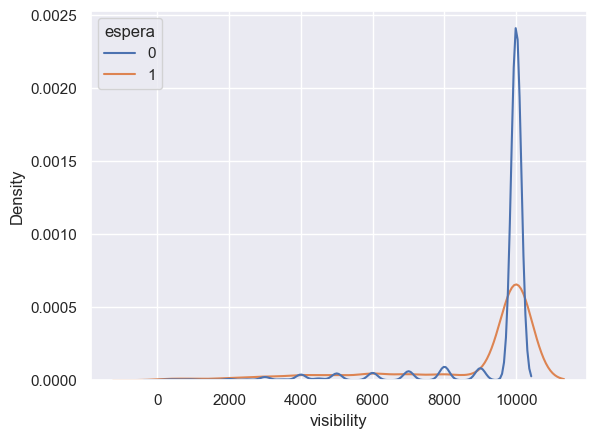

In [22]:
sns.kdeplot(data=main_ds[["visibility", "espera"]], hue="espera", x="visibility", common_norm=False)

<Axes: xlabel='wind_direction_rad', ylabel='Density'>

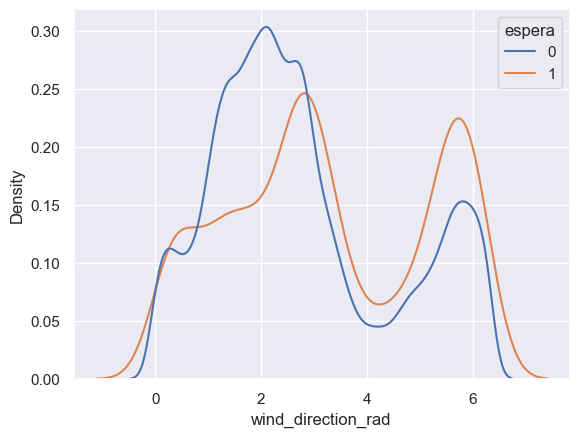

In [23]:
sns.kdeplot(data=main_ds[["wind_direction_rad", "espera"]], hue="espera", x="wind_direction_rad", common_norm=False)

<Axes: xlabel='wind_speed', ylabel='Density'>

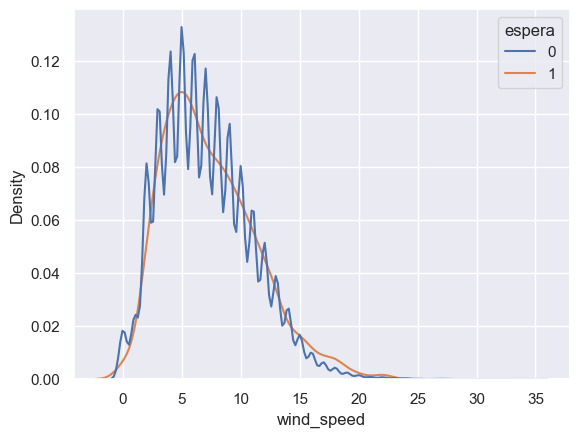

In [24]:
sns.kdeplot(data=main_ds[["wind_speed", "espera"]], hue="espera", x="wind_speed", common_norm=False)

---

In [27]:
full_ds = pl.concat([main_ds, pl.read_csv("image_color_data.csv", null_values="NA")], how="horizontal")
full_ds = full_ds.select([pl.all().exclude("espera"), pl.col("espera")])

In [28]:
full_ds

flightid,hora_ref,origem,destino,url_img_satelite,prev_troca_cabeceira,troca_cabeceira_hora_anterior,elevation,air_temperature,dew_point_temp,visibility,wind_direction_rad,wind_speed,wind_gust,low_cloud_type,low_cloud_level,medium_cloud_type,medium_cloud_level,high_cloud_type,high_cloud_level,highest_cloud_type,highest_cloud_level,cloud_coverage_oktas,altimeter,pressure_station_level_atm,sat_yellow_green,sat_purple_red,sat_blue,espera
str,str,str,str,str,i64,i64,i64,f64,f64,i64,f64,f64,str,str,f64,str,f64,str,f64,str,f64,i64,f64,f64,f64,f64,f64,i64
"""504a62621cd231…","""2022-06-01T01:…","""SBCF""","""SBFL""","""http://satelit…",0,1,5,14.0,7.0,9999,2.96706,9.0,null,"""BKN""",3000.0,null,null,null,null,null,null,6,30.120583,1.006362,0.24016,0.031169,0.063786,0
"""b0fd0f83644625…","""2022-06-01T01:…","""SBPA""","""SBFL""","""http://satelit…",0,1,5,14.0,7.0,9999,2.96706,9.0,null,"""BKN""",3000.0,null,null,null,null,null,null,6,30.120583,1.006362,0.000376,0.0,0.0,0
"""1210f0ca07ddca…","""2022-06-01T01:…","""SBSP""","""SBCF""","""http://satelit…",0,0,828,21.0,14.0,10000,2.094395,6.0,null,null,null,null,null,null,null,null,null,0,30.061523,0.910229,0.272527,0.084537,0.091209,0
"""b25032f34507cc…","""2022-06-01T01:…","""SBGR""","""SBCT""","""http://satelit…",0,0,908,10.0,10.0,7000,1.745329,6.0,null,"""BKN""",400.0,"""OVC""",1200.0,null,null,null,null,8,30.091053,0.902375,0.437748,0.112204,0.067739,0
"""00762a9892ecba…","""2022-06-01T01:…","""SBSP""","""SBSV""","""http://satelit…",0,1,6,27.0,21.0,9999,1.919862,8.0,null,"""FEW""",2300.0,null,null,null,null,null,null,2,29.943403,1.000324,0.126246,0.04079,0.042082,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""0a98b5dca23575…","""2023-02-16T13:…","""SBCT""","""SBSP""","""http://satelit…",0,0,803,23.0,17.0,9999,6.108652,14.0,null,"""SCT""",3000.0,null,null,null,null,null,null,4,29.854813,0.906588,0.0,0.0,0.029754,0
"""000143522a56fa…","""2023-02-16T13:…","""SBSP""","""SBRF""","""http://satelit…",0,0,19,29.0,23.0,9999,1.745329,7.0,null,"""BKN""",2000.0,null,null,null,null,null,null,6,29.854813,0.995828,0.000055,0.0,0.027563,0
"""1067786192e3ee…","""2023-02-16T13:…","""SBSP""","""SBRJ""","""http://satelit…",0,0,3,29.0,22.0,9999,5.585054,10.0,null,"""FEW""",3500.0,"""BKN""",10000.0,null,null,null,null,6,29.677633,0.9918,0.0,0.0,0.027829,0


<Axes: xlabel='sat_yellow_green', ylabel='Density'>

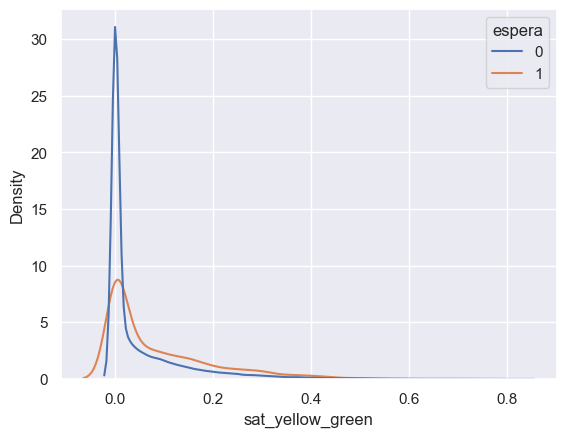

In [33]:
sns.kdeplot(data=full_ds[["sat_yellow_green", "espera"]], hue="espera", x="sat_yellow_green", common_norm=False)

<Axes: xlabel='sat_purple_red', ylabel='Density'>

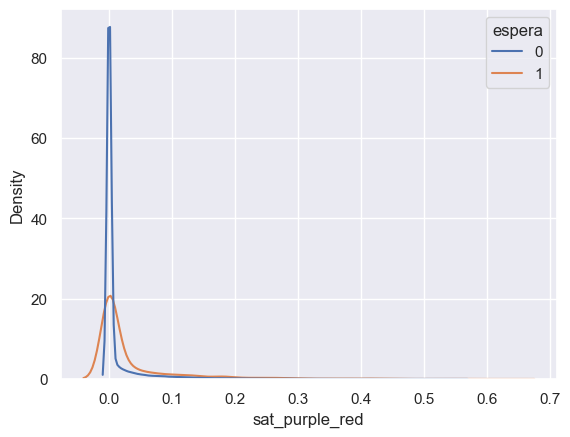

In [34]:
sns.kdeplot(data=full_ds[["sat_purple_red", "espera"]], hue="espera", x="sat_purple_red", common_norm=False)

<Axes: xlabel='sat_blue', ylabel='Density'>

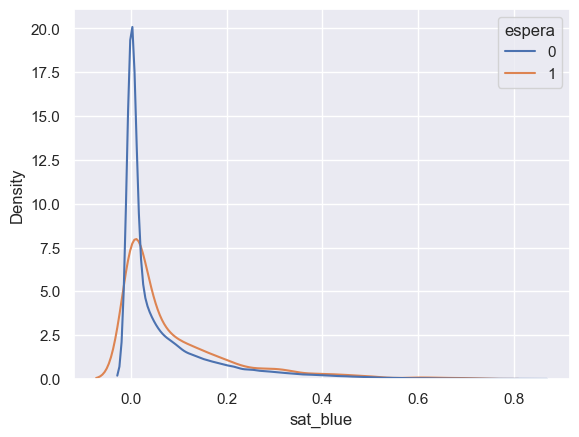

In [35]:
sns.kdeplot(data=full_ds[["sat_blue", "espera"]], hue="espera", x="sat_blue", common_norm=False)

In [36]:
full_ds.write_csv("merged_train_val.csv", null_value="NA") 